In [25]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.evaluation import RegressionEvaluator, ClusteringEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.mllib.linalg import SparseMatrix
from pyspark.ml.linalg import SparseVector
from pyspark.ml.evaluation import RankingEvaluator
from pyspark.sql import Row
import datetime
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import copy
import sys
import os
from pyspark.sql.functions import array_intersect
from pyspark.sql.functions import pandas_udf, PandasUDFType, col
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import collect_list, expr
from scipy.spatial.distance import cosine

In [2]:
os.environ["PYSPARK_PYTHON"] = sys.executable
project_path = os.path.abspath(os.path.dirname("."))
data_path = os.path.join(project_path, "ml-32m")
java_path = "C:\\Program Files\\Java\\jdk1.8.0_202"
hadoop_path = "C:\\Program Files\\Hadoop\\hadoop-3.3.6\\bin"
os.environ["HADOOP_HOME"] = os.path.dirname(hadoop_path)
os.environ["PATH"] += os.pathsep + hadoop_path

In [3]:
spark = SparkSession.builder \
    .appName("ExampleApp") \
    .config("spark.ui.showConsoleProgress", "true") \
    .config("spark.executorEnv.JAVA_HOME", java_path) \
    .config("spark.driverEnv.JAVA_HOME", java_path) \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.executor.resource.gpu.amount", 6) \
    .config("spark.hadoop.fs.file.impl", "org.apache.hadoop.fs.LocalFileSystem") \
    .config("spark.hadoop.fs.file.impl.disable.cache", "true") \
    .config("spark.hadoop.home.dir", hadoop_path) \
    .getOrCreate()

In [4]:
ratings = (spark.read.option("header", True)
                .csv(os.path.join(data_path, "ratings.csv")))
links = (spark.read.option("header", True)
              .csv(os.path.join(data_path, "links.csv")))
movies = (spark.read.option("header", True)
               .csv(os.path.join(data_path, "movies.csv")))
movies = movies.withColumn(
    "genres",
    F.when(F.col("movieId") == 284105, "Comedy") \
     .otherwise(F.col("genres"))
)
tags = (spark.read.option("header", True)
             .csv(os.path.join(data_path, "tags.csv")))
movies.show(1), links.show(1), ratings.show(1), tags.show(1)

+-------+----------------+--------------------+
|movieId|           title|              genres|
+-------+----------------+--------------------+
|      1|Toy Story (1995)|Adventure|Animati...|
+-------+----------------+--------------------+
only showing top 1 row

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
+-------+-------+------+
only showing top 1 row

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|     17|   4.0|944249077|
+------+-------+------+---------+
only showing top 1 row

+------+-------+-----------+----------+
|userId|movieId|        tag| timestamp|
+------+-------+-----------+----------+
|    22|  26479|Kevin Kline|1583038886|
+------+-------+-----------+----------+
only showing top 1 row



(None, None, None, None)

Identification keys

id | type | present in | description
---|------|---------|------------
userId | int | ratings, tags | unique identifier for the user
movieId | int | links, movies, ratings, tags  | unique identifier for the movie
rating | float | ratings | rating given by the user to the movie
timestamp | int | ratings | timestamp of the rating
tag | str | tags | tag given by the user to the movie
title | str | movies | title of the movie
genres | str | movies | genres of the movie
imdbId | int | links | unique identifier for the movie in IMDb
tmdbId | int | links | TMDb identifier for the movie


In [5]:
ratings = (ratings.withColumn("rating", ratings["rating"].cast("float"))
                  .withColumn("userId", ratings["userId"].cast("int"))
                  .withColumn("movieId", ratings["movieId"].cast("int"))
        )
movies = movies.withColumn("movieId", movies["movieId"].cast("int"))

```python
movie_data = movies.join(links, "movieId", "outer") 
movie_data.show(5)
```


## Statistics

In [ ]:
number_of_users = ratings.select("userId").distinct().count()
number_of_movies = ratings.select("movieId").distinct().count()
number_of_ratings = ratings.count()
print("Number of ratings: ", number_of_ratings)
print("Number of users: ", number_of_users)
print("Number of movies: ", number_of_movies)

matrix_sparsity = (ratings.count() / (number_of_users * number_of_movies)) * 100
print("Matrix sparsity: ", matrix_sparsity)

print()
users_grouped = ratings.groupBy("userId")
movies_grouped = ratings.groupBy("movieId")
users_rated = users_grouped.count()
movies_rated = movies_grouped.count()
print("Average number of ratings per user: ", users_rated.agg(F.mean("count")).collect()[0][0])
print("Average number of ratings per movie: ", movies_rated.agg(F.mean("count")).collect()[0][0])
print("Mean rating:", ratings.agg(F.mean("rating")).collect()[0][0])
print("Mean rating per user:", users_grouped.agg(F.mean("rating")).agg(F.mean("avg(rating)")).collect()[0][0])
print("Mean rating per movie:", movies_grouped.agg(F.mean("rating")).agg(F.mean("avg(rating)")).collect()[0][0])    

Number of ratings:  32000204
Number of users:  200948
Number of movies:  84432
Matrix sparsity:  0.18860881306254365

Average number of ratings per user:  159.24619304496684
Average number of ratings per movie:  379.0056376729202
Mean rating: 3.5403956487277393
Mean rating per user: 3.7043683389640747
Mean rating per movie: 3.005082384974346


## Data Split

We need to observe whether the data is dependent of the time. If it is dependent, we need to split the data into training and test sets based on time. If it is not dependent, we can randomly split the data into training and test sets using `TrainValidationSplit` from the `pyspark.ml.tuning` module. We will implement this in the next steps to ensure our model is trained effectively based on the data characteristics.

In [6]:
ratings = ratings.withColumn("year", F.year(F.from_unixtime(F.col("timestamp"))))
yearly_trends = (ratings.groupBy("year")
                        .agg(
                            F.avg("rating").alias("avg_rating"), 
                            F.count("*").alias("num_ratings")
                        )
                        .orderBy("year")
                )
yearly_trends.show()

+----+------------------+-----------+
|year|        avg_rating|num_ratings|
+----+------------------+-----------+
|1995|              3.75|          4|
|1996| 3.546167818775827|    1571755|
|1997| 3.588877064986213|     685053|
|1998|3.5139587387572564|     301639|
|1999|3.6165843810879057|    1174973|
|2000|3.5765982885160987|    1912843|
|2001| 3.533412327380055|    1160425|
|2002|3.4843305279265495|     849550|
|2003|3.4744290444191424|    1010893|
|2004|3.4303692033580697|    1139345|
|2005|3.4341227737238778|    1752085|
|2006|3.4658399484224525|    1141582|
|2007|3.4704753998290805|    1023875|
|2008| 3.540532513412135|    1117831|
|2009| 3.507221597932352|     889900|
|2010| 3.534047079568612|     859736|
|2011|3.5623316781542402|     729629|
|2012|3.6088359437179807|     696066|
|2013|3.6453152802441684|     562563|
|2014|3.6117663393525197|     518564|
+----+------------------+-----------+
only showing top 20 rows



In [11]:
yearly_trends.agg(F.mean('avg_rating').alias("mean_rating"), 
                  F.median('avg_rating').alias("median_rating"), 
                  F.stddev('avg_rating').alias("std_rating"), 
                  F.max('avg_rating').alias("max_rating"), 
                  F.min('avg_rating').alias("min_rating")).show()

+------------------+-----------------+-------------------+----------+------------------+
|       mean_rating|    median_rating|         std_rating|max_rating|        min_rating|
+------------------+-----------------+-------------------+----------+------------------+
|3.5496523638495314|3.548434711534148|0.06706141615685407|      3.75|3.4303692033580697|
+------------------+-----------------+-------------------+----------+------------------+



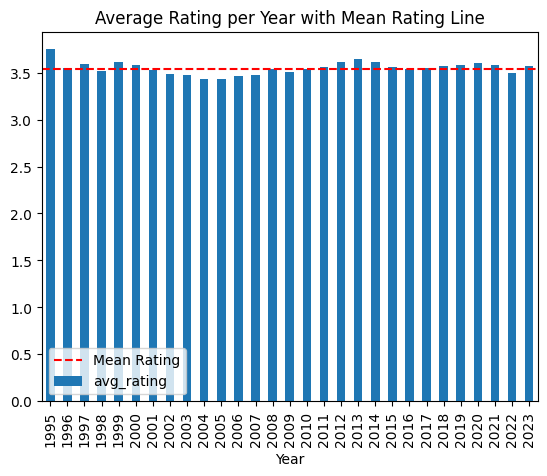

In [12]:
mean_rating = ratings.agg(F.mean("rating")).collect()[0][0]
yearly_trends.toPandas().plot(x="year", y="avg_rating", kind="bar", title="Average Rating per Year")
plt.axhline(mean_rating, color='r', linestyle='--', label='Mean Rating')
plt.xlabel("Year")
plt.legend()
plt.title("Average Rating per Year with Mean Rating Line")
plt.show()

We can observe that the data is independent of the time. Therefore, we can randomly split the data into training and test sets using `TrainValidationSplit` from the `pyspark.ml.tuning` module.

In [6]:
train_ratings, test_ratings = ratings.randomSplit([0.8, 0.2], seed=42)

## Data exploration

In [17]:
users_grouped = train_ratings.groupBy("userId")
movies_grouped = train_ratings.groupBy("movieId")
number_of_ratings = train_ratings.count()

In [ ]:
number_of_users = train_ratings.select("userId").distinct().count()
number_of_movies = train_ratings.select("movieId").distinct().count()
number_of_ratings = train_ratings.count()
print("Number of ratings: ", number_of_ratings)
print("Number of users: ", number_of_users)
print("Number of movies: ", number_of_movies)

matrix_sparsity = (train_ratings.count() / (number_of_users * number_of_movies)) * 100
print("Matrix sparsity: ", matrix_sparsity)

print()
users_rated = users_grouped.count()
movies_rated = movies_grouped.count()
print("Average number of ratings per user: ", users_rated.agg(F.mean("count")).collect()[0][0])
print("Average number of ratings per movie: ", movies_rated.agg(F.mean("count")).collect()[0][0])
print("Mean rating:", train_ratings.agg(F.mean("rating")).collect()[0][0])
print("Mean rating per user:", users_grouped.agg(F.mean("rating")).agg(F.mean("avg(rating)")).collect()[0][0])
print("Mean rating per movie:", movies_grouped.agg(F.mean("rating")).agg(F.mean("avg(rating)")).collect()[0][0])    

Number of ratings:  25600446
Number of users:  200948
Number of movies:  80185
Matrix sparsity:  0.1588805409555812

Average number of ratings per user:  127.39836176523279
Average number of ratings per movie:  319.26726943942134
Mean rating: 3.5403927142519316
Mean rating per user: 3.7044770806023575
Mean rating per movie: 3.015131601139284


Matrix is sparse enough for collaborative filtering.

<Axes: xlabel='rating'>

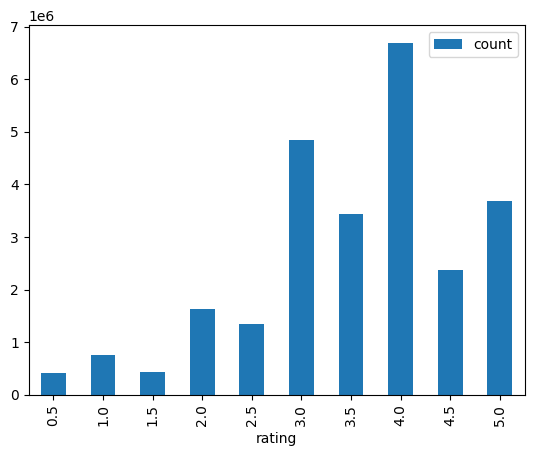

In [12]:
ratings_distribution = train_ratings.groupBy("rating").count().toPandas().sort_values("rating")
ratings_distribution.plot(x="rating", y="count", kind="bar")

Here, we can observe that the ratings have a skewed distribution, with most ratings being 3 or 4 stars. In this case, we can use the `median` as a measure of central tendency.



In [12]:
user_count = users_grouped.count()
user_count_df = user_count.toPandas()

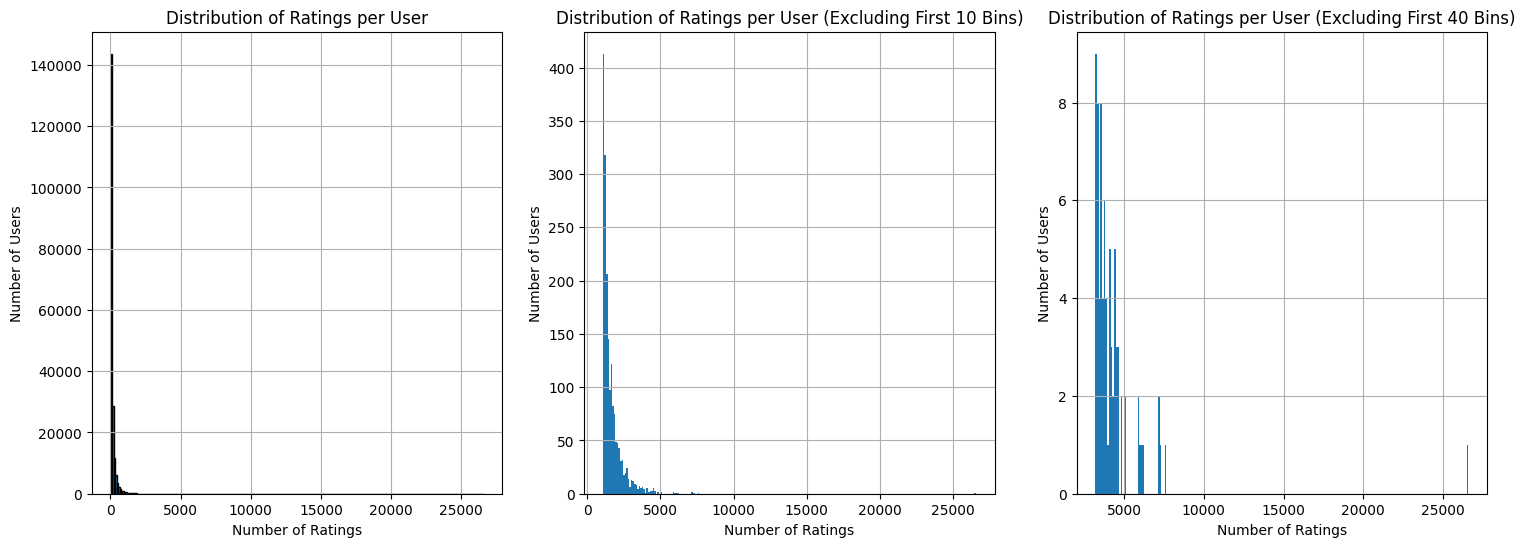

In [13]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
user_count_df["count"].hist(bins=250, edgecolor="black")
plt.title("Distribution of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")


plt.subplot(1, 3, 2)
# Determine the bin edges
bin_edges = user_count_df["count"].quantile([i / 250 for i in range(200)])  # First 10 bins

# Filter out data within the first 10 bins
bin_size = (user_count_df['count'].max() - user_count_df['count'].min()) / 250 
filtered_user_count_df = user_count_df[user_count_df["count"] > bin_size * 10]

# Plot the histogram
filtered_user_count_df["count"].hist(bins=240)  # Adjust bins accordingly
plt.title("Distribution of Ratings per User (Excluding First 10 Bins)")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")

plt.subplot(1, 3, 3)
# Filter out data within the first 40 bins
bin_size = (user_count_df['count'].max() - user_count_df['count'].min()) / 250 
filtered_user_count_df = user_count_df[user_count_df["count"] > bin_size * 30]

# Plot the histogram
filtered_user_count_df["count"].hist(bins=220)  # Adjust bins accordingly
plt.title("Distribution of Ratings per User (Excluding First 40 Bins)")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")
plt.show()

Many users have rated only a few movies, and many movies have been rated by only a few users.

In [14]:
movies_count = movies_grouped.count()
movies_count_df = movies_count.toPandas()

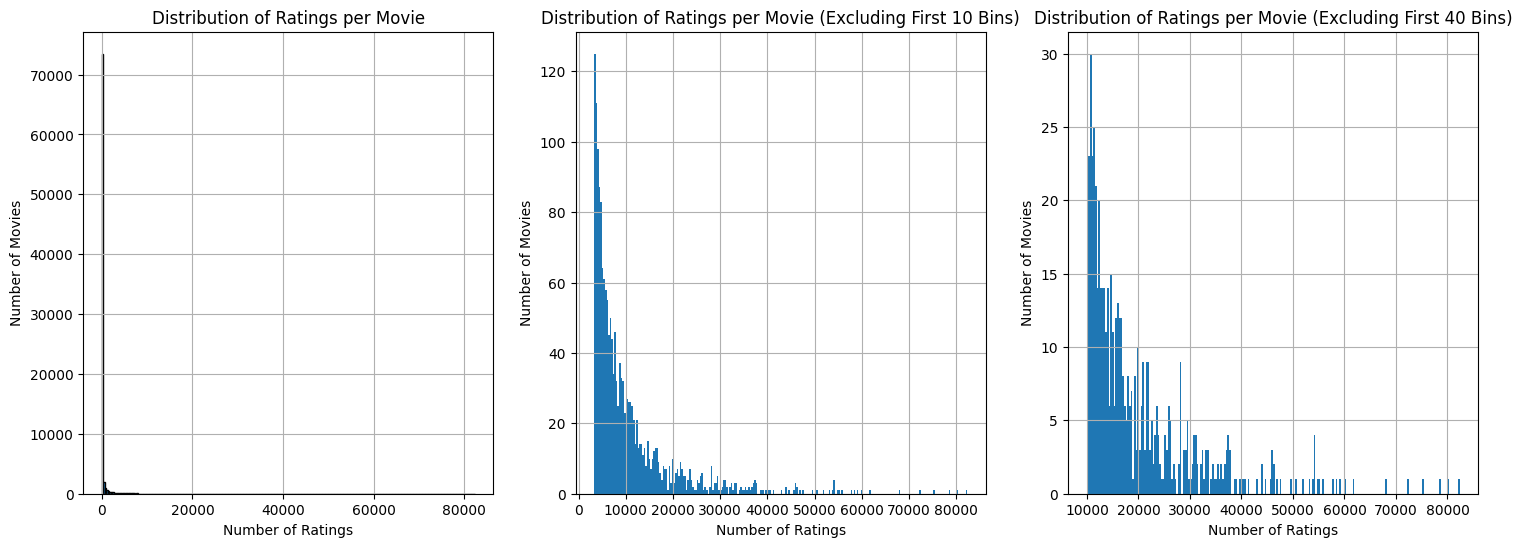

In [14]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
movies_count_df["count"].hist(bins=250, edgecolor="black")
plt.title("Distribution of Ratings per Movie")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies")


plt.subplot(1, 3, 2)
# Determine the bin edges
bin_edges = movies_count_df["count"].quantile([i / 250 for i in range(200)])  # First 10 bins

# Filter out data within the first 10 bins
bin_size = (movies_count_df['count'].max() - movies_count_df['count'].min()) / 250 
filtered_movies_count_df = movies_count_df[movies_count_df["count"] > bin_size * 10]

# Plot the histogram
filtered_movies_count_df["count"].hist(bins=240)  # Adjust bins accordingly
plt.title("Distribution of Ratings per Movie (Excluding First 10 Bins)")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies")

plt.subplot(1, 3, 3)
# Filter out data within the first 40 bins
bin_size = (movies_count_df['count'].max() - movies_count_df['count'].min()) / 250 
filtered_movies_count_df = movies_count_df[movies_count_df["count"] > bin_size * 30]

# Plot the histogram
filtered_movies_count_df["count"].hist(bins=220)  # Adjust bins accordingly
plt.title("Distribution of Ratings per Movie (Excluding First 40 Bins)")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies")
plt.show()

Long tail: We can observe that movies which are frequently rated by users are few in number. This is a good sign for neighbourhood-based collaborative filtering.

In many cases, ratings of these high frequency movies are not representative of the ratings of low-frequency movies. because of the inherent differences in raing patterns of the 2 classes of items. As a result, prediction process may yield misleading results.

If we provide commonly rated movies as input to the model, it may not be able to learn the rating patterns of low-frequency movies. This is because the model will be biased towards the rating patterns of high-frequency movies and the user may not be able to get the desired recommendations.

Therefore, we can utilize the notion of `Inverse User Frequency` to address this issue. This will help us to balance the rating patterns of high-frequency and low-frequency movies. 

For each movie $j$ with ratings $m_j$ and total number of ratings $m$, we can calculate the inverse user frequency as follows: 
$$w_j = \log \bigg(\frac{m}{m_j}\bigg)$$

In [18]:
movie_weights = movies_count.withColumn(
    "weight", F.log(number_of_ratings / F.col("count")))
(movie_weights.join(movies, "movieId")
              .orderBy("weight", ascending=False)
              .show(10))

+-------+-----+------------------+--------------------+--------------------+
|movieId|count|            weight|               title|              genres|
+-------+-----+------------------+--------------------+--------------------+
| 146090|    1|17.058120331173033|        Zenda (2009)|  (no genres listed)|
| 215975|    1|17.058120331173033| Schmeerguntz (1965)|              Comedy|
| 225699|    1|17.058120331173033|         Aura (2018)|              Horror|
| 235629|    1|17.058120331173033|  At Sundance (1995)|         Documentary|
| 291427|    1|17.058120331173033|Detective Conan: ...|Action|Animation|...|
| 138354|    1|17.058120331173033|Scattered Cloud (...|  (no genres listed)|
| 118274|    1|17.058120331173033|Legacy of Rage (1...|              Action|
| 139155|    1|17.058120331173033|Un fidanzato per ...|              Comedy|
| 267474|    1|17.058120331173033|   The Lodger (1967)|              Comedy|
| 272891|    1|17.058120331173033|The Other Woman (...|               Drama|

In [ ]:
# sum_of_weights = movie_weights.agg(F.sum("weight")).collect()[0][0]
# movie_weights_normalized = movie_weights.withColumn(
#     "weight", F.col("weight") / sum_of_weights
# )

## Metrics

We will use the following metrics to evaluate the model:
- RMSE: Root Mean Squared Error - Robustness of prediction across the range of ratings. Problem with it is it is sensitive to outliers, which can skew the results and lead to misleading conclusions. RMSE is not a true reflection of the average error.
- MAE: Mean Absolute Error - Better reflection of the accuracy when the importance of outliers is not high

Prediction of accuracies on sparse items is different from prediction of accuracies on dense items. So, to handle this, compute RMSE or MAE separately for all hidden ratings associated with each item and average over the different items in a weighted fashion. This is called weighted RMSE or weighted MAE.

## Baseline models
We will use a simple baseline model to predict the ratings. The model will be based on the average rating of each movie. This is a simple model that can be used as a baseline for more complex models. We will use the average rating of each movie as the predicted rating for that movie. This model is simple and easy to implement, but it can be improved by using more complex models such as collaborative filtering or content-based filtering.

In [ ]:
top_movies = (train_ratings
              .groupBy("movieId")
              .agg(F.avg("rating").alias("avg_rating"))
              .orderBy(F.desc("avg_rating"))
              .limit(10))

```
+-------+----------+
|movieId|avg_rating|
+-------+----------+
| 136998|       5.0|
| 137038|       5.0|
| 136988|       5.0|
| 200312|       5.0|
| 209821|       5.0|
| 137050|       5.0|
| 185241|       5.0|
| 135350|       5.0|
| 124893|       5.0|
| 206721|       5.0|
+-------+----------+
only showing top 10 rows
```

Explicit feedback implies that the user has rated the movie. 


Implicit feedback implies that the user has watched the movie but they did not rate. Since we do not have information about the user watching the movie, we will not be able to use implicit feedback. We will only use explicit feedback for the model. 


In [ ]:
explicit_baseline = train_ratings.join(
    top_movies, train_ratings.movieId == top_movies.movieId,
)
evaluator = RegressionEvaluator(
    labelCol="rating", predictionCol="avg_rating", metricName="rmse"
)
explicit_rmse = evaluator.evaluate(explicit_baseline)
print("Explicit RMSE: ", explicit_rmse)

Explicit RMSE:  2.0089087300607473


```python
test_users = test_movie_ratings.select("userId").distinct().select("userId")
users_top_movies = test_users.join(top_movies)
implicit_baseline = users_top_movies.join(
    test_movie_ratings, ["userId", "movieId"], "left"
).select(
    users_top_movies.userId, 
    users_top_movies.movieId,
    F.when(F.col("rating").isNull(), 0).otherwise(F.col("rating")).alias("rating"),   
    users_top_movies.avg_rating
)
implicit_rmse = evaluator.evaluate(implicit_baseline)
print("Implicit RMSE: ", implicit_rmse)
```

### Average rating


In [17]:
average_movie_rating = (train_ratings
              .groupBy("movieId")
              .agg(F.avg("rating").alias("avg_rating"))
              .orderBy(F.desc("avg_rating"))
              ).select("movieId", "avg_rating")

average_baseline = test_ratings.join(
    average_movie_rating, "movieId", "left"
).select(
    test_ratings.userId, 
    test_ratings.movieId,
    test_ratings.rating,
    F.when(F.col("avg_rating").isNull(), 0).otherwise(F.col("avg_rating")).alias("avg_rating")
)
rmse_evaluator = RegressionEvaluator(
    labelCol="rating", predictionCol="avg_rating", metricName="rmse"
)
average_rmse = rmse_evaluator.evaluate(average_baseline)
mae_evaluator = RegressionEvaluator(
    labelCol="rating", predictionCol="avg_rating", metricName="mae"
)
average_mae = mae_evaluator.evaluate(average_baseline)
print("RMSE:", average_rmse)
print("MAE:", average_mae)

RMSE: 0.963402602485829
MAE: 0.7422687164034186


In [28]:
# Step 1: Join weights
average_baseline_with_weights = average_baseline.join(
    movie_weights, "movieId", "left"
).select(
    average_baseline.userId, 
    average_baseline.movieId,
    average_baseline.rating,
    average_baseline.avg_rating,
    F.when(F.col("weight").isNull(), 0).otherwise(F.col("weight")).alias("weight")
)

# Step 2: Calculate absolute error
mae_predictions = average_baseline_with_weights.withColumn(
    "absolute_error", F.abs(F.col("rating") - F.col("avg_rating"))
)
rmse_predictions = average_baseline_with_weights.withColumn(
    "squared_error", F.pow(F.col("rating") - F.col("avg_rating"), 2)
)

# Step 3: Multiply absolute error by weight
mae_predictions = mae_predictions.withColumn(
    "weighted_error", F.col("absolute_error") * F.col("weight")
)
rmse_predictions = rmse_predictions.withColumn(
    "weighted_squared_error", F.col("squared_error") * F.col("weight")
)

# Step 4: Calculate Weighted MAE
weighted_rmse = rmse_predictions.agg(
    F.sqrt((F.sum("weighted_squared_error") / F.sum("weight"))).alias("weighted_rmse")
).collect()[0]["weighted_rmse"]
weighted_mae = mae_predictions.agg(
    (F.sum("weighted_error") / F.sum("weight")).alias("weighted_mae")
).collect()[0]["weighted_mae"]

print("Weighted RMSE:", weighted_rmse)
print("Weighted MAE:", weighted_mae)

Weighted RMSE: 0.9667046754972082
Weighted MAE: 0.7460749507679142


### Median rating

Since ratings are skewed, I expect the median rating to provide a more accurate reflection of user preferences. We will use median rating as the baseline for the model. This is a simple model that can be used as a baseline for more complex models. We will use the median rating of each movie as the predicted rating for that movie. This model is simple and easy to implement, but it can be improved by using more complex models such as collaborative filtering or content-based filtering.


In [7]:
median_movie_rating = (train_ratings
              .groupBy("movieId")
              .agg(F.median("rating").alias("median_rating"))
              .orderBy(F.desc("median_rating"))
              ).select("movieId", "median_rating")

median_baseline = test_ratings.join(
    median_movie_rating, "movieId", "left"
).select(
    test_ratings.userId, 
    test_ratings.movieId,
    test_ratings.rating,
    F.when(F.col("median_rating").isNull(), 0).otherwise(F.col("median_rating")).alias("median_rating")
)
rmse_evaluator = RegressionEvaluator(
    labelCol="rating", predictionCol="median_rating", metricName="rmse"
)
median_rmse = rmse_evaluator.evaluate(median_baseline)
mae_evaluator = RegressionEvaluator(
    labelCol="rating", predictionCol="median_rating", metricName="mae"
)
median_mae = mae_evaluator.evaluate(median_baseline)
print("RMSE:", median_rmse)
print("MAE:", median_mae)

RMSE: 0.9845125250844892
MAE: 0.7224906004258286


In [16]:
# Step 1: Join weights
median_baseline_with_weights = median_baseline.join(
    movie_weights, "movieId", "left"
).select(
    median_baseline.userId, 
    median_baseline.movieId,
    median_baseline.rating,
    median_baseline.median_rating,
    F.when(F.col("weight").isNull(), 0).otherwise(F.col("weight")).alias("weight")
)

# Step 2: Calculate absolute error
mae_predictions = median_baseline_with_weights.withColumn(
    "absolute_error", F.abs(F.col("rating") - F.col("median_rating"))
)
rmse_predictions = median_baseline_with_weights.withColumn(
    "squared_error", F.pow(F.col("rating") - F.col("median_rating"), 2)
)

# Step 3: Multiply absolute error by weight
mae_predictions = mae_predictions.withColumn(
    "weighted_error", F.col("absolute_error") * F.col("weight")
)
rmse_predictions = rmse_predictions.withColumn(
    "weighted_squared_error", F.col("squared_error") * F.col("weight")
)

# Step 4: Calculate Weighted MAE
weighted_rmse = rmse_predictions.agg(
    F.sqrt((F.sum("weighted_squared_error") / F.sum("weight"))).alias("weighted_rmse")
).collect()[0]["weighted_rmse"]
weighted_mae = mae_predictions.agg(
    (F.sum("weighted_error") / F.sum("weight")).alias("weighted_mae")
).collect()[0]["weighted_mae"]

print("Weighted RMSE:", weighted_rmse)
print("Weighted MAE:", weighted_mae)

Weighted RMSE: 0.9879927932541871
Weighted MAE: 0.7264651013046145


# k-NN

We can use User-based collaborative filtering to predict the ratings for the movies. We will use the following measures to compute the similarity between users:
- Pearson coefficient (Mean-centered rating): Subtracting the mean from the ratings of each user and then computing the correlation between the ratings of the two users. This is a good measure of similarity between users.
- Z score (Normalized rating): Subtracting the mean from the ratings of each user and then dividing by the standard deviation of the ratings of that user. This is a good measure of similarity between users when the ratings are not normally distributed.
- Cosine similarity: Computing the cosine of the angle between the ratings of the two users. This is a good measure of similarity between users when the ratings are not normally distributed. I believe this is not the best measure because some users provide very high ratings and some users provide very low ratings. This can skew the results and lead to misleading conclusions.
- Weighted Pearson coefficient: Impact of long tail is huge. So, we will use weighted Pearson coefficient to compute the similarity between users. This is a good measure of similarity between users when the ratings are not normally distributed. We will use this measure to compute the similarity between users and then use the similarity to predict the ratings for the movies.

We can use Movie-based collaborative filtering to predict the ratings for the movies. We will use the following measures to compute the similarity between movies:
- Adjusted cosine similarity: Subtracting the mean from the ratings of each movie and then computing the correlation between the ratings of the two movies. This is a good measure of similarity between movies.
- Pearson coefficient (Mean-centered rating): Subtracting the mean from the ratings of each movie and then computing the correlation between the ratings of the two movies. This is a good measure of similarity between movies. But adjusted cosine similarity is better than this measure.

Movie-based collaborative filtering is better than user-based collaborative filtering because there are many users who have rated only a few movies and many movies which have been rated by only a few users and a new movie can be suggested if the movie is similar to the movies that the user has already rated. This is not possible with user-based collaborative filtering because there are many users who have rated only a few movies and many movies which have been rated by only a few users. So, we will use movie-based collaborative filtering to predict the ratings for the movies.

# k-means heuristic

In [8]:
movies_onehot = movies.withColumn("genres", F.lower(F.col("genres")))
movies_onehot = movies_onehot.withColumn("genres", F.explode(F.split(F.col("genres"), "\\|")))
movies_onehot = movies_onehot.groupBy("movieId").pivot("genres").count().fillna(0)
movies_onehot.show(3)

+-------+------------------+------+---------+---------+--------+------+-----+-----------+-----+-------+---------+------+----+-------+-------+-------+------+--------+---+-------+
|movieId|(no genres listed)|action|adventure|animation|children|comedy|crime|documentary|drama|fantasy|film-noir|horror|imax|musical|mystery|romance|sci-fi|thriller|war|western|
+-------+------------------+------+---------+---------+--------+------+-----+-----------+-----+-------+---------+------+----+-------+-------+-------+------+--------+---+-------+
|  31528|                 0|     1|        1|        0|       0|     0|    0|          0|    1|      0|        0|     0|   0|      0|      0|      0|     0|       0|  1|      0|
|  40574|                 0|     1|        0|        0|       0|     0|    1|          0|    1|      0|        0|     0|   0|      0|      0|      0|     0|       0|  0|      0|
| 175513|                 0|     0|        0|        0|       0|     1|    0|          0|    0|      0|       

In [9]:
movie_feature_cols = movies_onehot.columns[1:]
movies_assembler = VectorAssembler(inputCols=movie_feature_cols, outputCol="features")
movies_onehot = movies_assembler.transform(movies_onehot).select("movieId", "features")
movies_onehot.show(3)

+-------+--------------------+
|movieId|            features|
+-------+--------------------+
|  31528|(20,[1,2,8,18],[1...|
|  40574|(20,[1,6,8],[1.0,...|
| 175513|      (20,[5],[1.0])|
+-------+--------------------+
only showing top 3 rows



In [9]:
kmeans_k_silhouette = []
max_trial_k = 402
jump_k = 8
for k in range(4, max_trial_k, jump_k):
    kmeans  = KMeans(k=k, seed=1, featuresCol="features", predictionCol="cluster")
    kmeans_model = kmeans.fit(movies_onehot)
    kmeans_predictions = kmeans_model.transform(movies_onehot)
    kmeans_evaluator = ClusteringEvaluator(predictionCol="cluster", featuresCol="features")
    kmeans_silhouette = kmeans_evaluator.evaluate(kmeans_predictions)
    kmeans_k_silhouette.append(kmeans_silhouette)
    print("KMeans Silhouette for k={}: ".format(k), kmeans_silhouette)

KMeans Silhouette for k=4:  0.24222970577819716
KMeans Silhouette for k=12:  0.4738618926103709
KMeans Silhouette for k=20:  0.5606061695435769
KMeans Silhouette for k=28:  0.6020039426897168
KMeans Silhouette for k=36:  0.6116452211251541
KMeans Silhouette for k=44:  0.6075656203146284
KMeans Silhouette for k=52:  0.6650202273386302
KMeans Silhouette for k=60:  0.6800371416834112
KMeans Silhouette for k=68:  0.6909583308520859
KMeans Silhouette for k=76:  0.6920036998114443
KMeans Silhouette for k=84:  0.7214286943861922
KMeans Silhouette for k=92:  0.7340712354947614
KMeans Silhouette for k=100:  0.7493318679448644
KMeans Silhouette for k=108:  0.7619219612743282
KMeans Silhouette for k=116:  0.7639179536903212
KMeans Silhouette for k=124:  0.7836632741331562
KMeans Silhouette for k=132:  0.7908585516291085
KMeans Silhouette for k=140:  0.7988819858642486
KMeans Silhouette for k=148:  0.8048020696230508
KMeans Silhouette for k=156:  0.8207905039525566
KMeans Silhouette for k=164:  0.

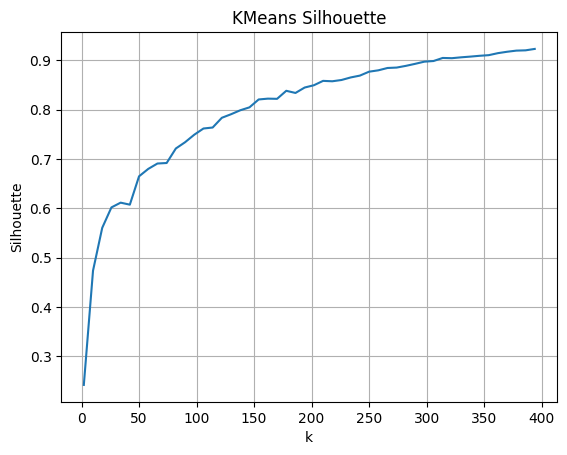

In [11]:
plt.plot(range(2, max_trial_k, jump_k), kmeans_k_silhouette)
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.title("KMeans Silhouette")
plt.grid()
plt.show()

In [10]:
kmeans  = KMeans(k=150, seed=1, featuresCol="features", predictionCol="cluster")
kmeans_model = kmeans.fit(movies_onehot)
kmeans_predictions = kmeans_model.transform(movies_onehot)
movie_clusters = kmeans_predictions.select("movieId", "cluster").withColumnRenamed("cluster", "kmeans_cluster")
movie_clusters.show(3)

+-------+--------------+
|movieId|kmeans_cluster|
+-------+--------------+
|  31528|            30|
|  40574|            67|
| 175513|             3|
+-------+--------------+
only showing top 3 rows



In [40]:
train_movie_clusters = train_ratings.join(
    movie_clusters, "movieId", "left"
)
train_cluster_rating_groupby = (train_movie_clusters
                .groupBy("kmeans_cluster", "userId")
                .agg(
                    F.avg("rating").alias("cluster_avg_rating"),
                    F.median("rating").alias("cluster_median_rating")
                )
                .orderBy(F.desc("cluster_avg_rating"))
                ).select("kmeans_cluster", "userId", "cluster_avg_rating", "cluster_median_rating")

test_movie_clusters = test_ratings.join(
    movie_clusters, "movieId", "left"
)
test_cluster_ratings = test_movie_clusters.join(
    train_cluster_rating_groupby, ["kmeans_cluster", "userId"], "left"
).withColumn(
    "cluster_avg_rating", 
    F.when(F.col("cluster_avg_rating").isNull(), 0).otherwise(F.col("cluster_avg_rating"))
).withColumn(
    "cluster_median_rating", 
    F.when(F.col("cluster_median_rating").isNull(), 0).otherwise(F.col("cluster_median_rating"))
)
test_cluster_ratings.show(3)

+--------------+------+-------+------+----------+----+------------------+---------------------+
|kmeans_cluster|userId|movieId|rating| timestamp|year|cluster_avg_rating|cluster_median_rating|
+--------------+------+-------+------+----------+----+------------------+---------------------+
|             3|     1|    223|   3.0| 944082810|1999|3.7777777777777777|                  4.0|
|           108|  9048|   2393|   2.5|1261636975|2009|               4.5|                  4.5|
|             3|152166|  48385|   3.5|1612201157|2021|            3.9375|                  4.0|
+--------------+------+-------+------+----------+----+------------------+---------------------+
only showing top 3 rows



### Average from k-means

In [22]:
rmse_evaluator = RegressionEvaluator(
    labelCol="rating", predictionCol="cluster_avg_rating", metricName="rmse"
)
cluster_rmse = rmse_evaluator.evaluate(test_cluster_ratings)
mae_evaluator = RegressionEvaluator(
    labelCol="rating", predictionCol="cluster_avg_rating", metricName="mae"
)
cluster_mae = mae_evaluator.evaluate(test_cluster_ratings)
print("RMSE:", cluster_rmse)
print("MAE:", cluster_mae)

# Step 1: Join weights
test_cluster_ratings_with_weights = test_cluster_ratings.join(
    movie_weights, "movieId", "left"
).select(
    test_cluster_ratings.userId, 
    test_cluster_ratings.movieId,
    test_cluster_ratings.rating,
    test_cluster_ratings.cluster_avg_rating,
    F.when(F.col("weight").isNull(), 0).otherwise(F.col("weight")).alias("weight")
)

# Step 2: Calculate absolute error
mae_predictions = test_cluster_ratings_with_weights.withColumn(
    "absolute_error", F.abs(F.col("rating") - F.col("cluster_avg_rating"))
)
rmse_predictions = test_cluster_ratings_with_weights.withColumn(
    "squared_error", F.pow(F.col("rating") - F.col("cluster_avg_rating"), 2)
)

# Step 3: Multiply absolute error by weight
mae_predictions = mae_predictions.withColumn(
    "weighted_error", F.col("absolute_error") * F.col("weight")
)
rmse_predictions = rmse_predictions.withColumn(
    "weighted_squared_error", F.col("squared_error") * F.col("weight")
)

# Step 4: Calculate Weighted MAE
weighted_rmse = rmse_predictions.agg(
    F.sqrt((F.sum("weighted_squared_error") / F.sum("weight"))).alias("weighted_rmse")
).collect()[0]["weighted_rmse"]
weighted_mae = mae_predictions.agg(
    (F.sum("weighted_error") / F.sum("weight")).alias("weighted_mae")
).collect()[0]["weighted_mae"]

print("Weighted RMSE:", weighted_rmse)
print("Weighted MAE:", weighted_mae)

RMSE: 1.7920258158551299
MAE: 1.2221473141135588
Weighted RMSE: 1.7379092677955603
Weighted MAE: 1.1820002496695707


### Average from Median

In [33]:
rmse_evaluator = RegressionEvaluator(
    labelCol="rating", predictionCol="cluster_median_rating", metricName="rmse"
)
cluster_rmse = rmse_evaluator.evaluate(test_cluster_ratings)
mae_evaluator = RegressionEvaluator(
    labelCol="rating", predictionCol="cluster_median_rating", metricName="mae"
)
cluster_mae = mae_evaluator.evaluate(test_cluster_ratings)
print("RMSE:", cluster_rmse)
print("MAE:", cluster_mae)

# Step 1: Join weights
test_cluster_ratings_with_weights = test_cluster_ratings.join(
    movie_weights, "movieId", "left"
).select(
    test_cluster_ratings.userId, 
    test_cluster_ratings.movieId,
    test_cluster_ratings.rating,
    test_cluster_ratings.cluster_median_rating,
    F.when(F.col("weight").isNull(), 0).otherwise(F.col("weight")).alias("weight")
)

# Step 2: Calculate absolute error
mae_predictions = test_cluster_ratings_with_weights.withColumn(
    "absolute_error", F.abs(F.col("rating") - F.col("cluster_median_rating"))
)
rmse_predictions = test_cluster_ratings_with_weights.withColumn(
    "squared_error", F.pow(F.col("rating") - F.col("cluster_median_rating"), 2)
)

# Step 3: Multiply absolute error by weight
mae_predictions = mae_predictions.withColumn(
    "weighted_error", F.col("absolute_error") * F.col("weight")
)
rmse_predictions = rmse_predictions.withColumn(
    "weighted_squared_error", F.col("squared_error") * F.col("weight")
)

# Step 4: Calculate Weighted MAE
weighted_rmse = rmse_predictions.agg(
    F.sqrt((F.sum("weighted_squared_error") / F.sum("weight"))).alias("weighted_rmse")
).collect()[0]["weighted_rmse"]
weighted_mae = mae_predictions.agg(
    (F.sum("weighted_error") / F.sum("weight")).alias("weighted_mae")
).collect()[0]["weighted_mae"]

print("Weighted RMSE:", weighted_rmse)
print("Weighted MAE:", weighted_mae)

RMSE: 1.8070506869183274
MAE: 1.2159590253256451
Weighted RMSE: 1.7542431993197327
Weighted MAE: 1.1759189610245813


### Average from top k

In [45]:
from pyspark.sql import Window
from pyspark.sql.functions import col, row_number, avg

k = 10

# Define a window specification to rank rows by rating within each userId
window_spec = Window.partitionBy("kmeans_cluster", "userId").orderBy(col("rating").desc())

# Add a rank column to identify the top k ratings for each userId
ranked_df = train_movie_clusters.withColumn("rank", row_number().over(window_spec))

# Filter the top k rows for each userId
top_k_df = ranked_df.filter(col("rank") <= k)

# Calculate the average of the top k ratings for each userId
average_top_k = top_k_df.groupBy("kmeans_cluster", "userId") \
                        .agg(avg("rating").alias("avg_top_k_rating"))

test_movie_clusters = test_ratings.join(
    movie_clusters, "movieId", "left"
)
test_cluster_ratings = test_movie_clusters.join(
    average_top_k, ["kmeans_cluster", "userId"], "left"
).withColumn(
    "avg_top_k_rating", 
    F.when(F.col("avg_top_k_rating").isNull(), 0).otherwise(F.col("avg_top_k_rating"))
)

In [46]:
rmse_evaluator = RegressionEvaluator(
    labelCol="rating", predictionCol="avg_top_k_rating", metricName="rmse"
)
cluster_rmse = rmse_evaluator.evaluate(test_cluster_ratings)
mae_evaluator = RegressionEvaluator(
    labelCol="rating", predictionCol="avg_top_k_rating", metricName="mae"
)
cluster_mae = mae_evaluator.evaluate(test_cluster_ratings)
print("RMSE:", cluster_rmse)
print("MAE:", cluster_mae)

# Step 1: Join weights
test_cluster_ratings_with_weights = test_cluster_ratings.join(
    movie_weights, "movieId", "left"
).select(
    test_cluster_ratings.userId, 
    test_cluster_ratings.movieId,
    test_cluster_ratings.rating,
    test_cluster_ratings.avg_top_k_rating,
    F.when(F.col("weight").isNull(), 0).otherwise(F.col("weight")).alias("weight")
)

# Step 2: Calculate absolute error
mae_predictions = test_cluster_ratings_with_weights.withColumn(
    "absolute_error", F.abs(F.col("rating") - F.col("avg_top_k_rating"))
)
rmse_predictions = test_cluster_ratings_with_weights.withColumn(
    "squared_error", F.pow(F.col("rating") - F.col("avg_top_k_rating"), 2)
)

# Step 3: Multiply absolute error by weight
mae_predictions = mae_predictions.withColumn(
    "weighted_error", F.col("absolute_error") * F.col("weight")
)
rmse_predictions = rmse_predictions.withColumn(
    "weighted_squared_error", F.col("squared_error") * F.col("weight")
)

# Step 4: Calculate Weighted MAE
weighted_rmse = rmse_predictions.agg(
    F.sqrt((F.sum("weighted_squared_error") / F.sum("weight"))).alias("weighted_rmse")
).collect()[0]["weighted_rmse"]
weighted_mae = mae_predictions.agg(
    (F.sum("weighted_error") / F.sum("weight")).alias("weighted_mae")
).collect()[0]["weighted_mae"]

print("Weighted RMSE:", weighted_rmse)
print("Weighted MAE:", weighted_mae)

RMSE: 1.853757323265893
MAE: 1.2979657359204226
Weighted RMSE: 1.81532649454268
Weighted MAE: 1.2757878037766963


## ALS

In [7]:
als_model = ALS(
    maxIter=5,
    regParam=0.01,
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop",
    implicitPrefs=False,
    nonnegative=True,
    rank=10,
    seed=42,
)
als_model.setPredictionCol("prediction")

ALS_7b96675416b1

In [8]:
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
param_grid = ParamGridBuilder() \
    .addGrid(als_model.rank, [13, 15, 17]) \
    .addGrid(als_model.maxIter, [19, 20]) \
    .addGrid(als_model.regParam, [.18, .19]) \
    .build()

evaluator = RegressionEvaluator(
    labelCol="rating", predictionCol="prediction", metricName="rmse"
)

# tvs = TrainValidationSplit(
#     estimator=als_model,
#     # estimatorParamMaps=param_grid,
#     evaluator=evaluator,
#     trainRatio=0.8,
# )

cross_validator = CrossValidator(
    estimator=als_model,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=2,  # Adjust based on your cluster size
)

In [9]:
train = False
model = None
if train == True:
    model = cross_validator.fit(train_ratings)
    # Save the ALS model
    model.write().overwrite().save(os.path.join(project_path, "als_model"))
else:
    # Load the ALS model
    model = CrossValidatorModel.load(os.path.join(project_path, "als_model"))
    
best_model = model.bestModel

In [10]:
predictions = best_model.transform(test_ratings)
als_rmse = evaluator.evaluate(predictions)
mae_evaluator = RegressionEvaluator(
    labelCol="rating", predictionCol="prediction", metricName="mae"
)
als_mae = mae_evaluator.evaluate(predictions)
print("ALS RMSE: ", als_rmse)
print("ALS MAE: ", als_mae)

ALS RMSE:  0.8493693300259775
ALS MAE:  0.6628882806698647


In [19]:
# Step 1: Join weights
als_predictions_with_weights = predictions.join(
    movie_weights, "movieId", "left"
).select(
    predictions.userId, 
    predictions.movieId,
    predictions.rating,
    predictions.prediction,
    F.when(F.col("weight").isNull(), 0).otherwise(F.col("weight")).alias("weight")
)

# Step 2: Calculate absolute error
mae_predictions = als_predictions_with_weights.withColumn(
    "absolute_error", F.abs(F.col("rating") - F.col("prediction"))
)
rmse_predictions = als_predictions_with_weights.withColumn(
    "squared_error", F.pow(F.col("rating") - F.col("prediction"), 2)
)

# Step 3: Multiply absolute error by weight
mae_predictions = mae_predictions.withColumn(
    "weighted_error", F.col("absolute_error") * F.col("weight")
)
rmse_predictions = rmse_predictions.withColumn(
    "weighted_squared_error", F.col("squared_error") * F.col("weight")
)

# Step 4: Calculate Weighted MAE
weighted_rmse = rmse_predictions.agg(
    F.sqrt((F.sum("weighted_squared_error") / F.sum("weight"))).alias("weighted_rmse")
).collect()[0]["weighted_rmse"]
weighted_mae = mae_predictions.agg(
    (F.sum("weighted_error") / F.sum("weight")).alias("weighted_mae")
).collect()[0]["weighted_mae"]

print("Weighted RMSE:", weighted_rmse)
print("Weighted MAE:", weighted_mae)

Weighted RMSE: 0.8511551928349687
Weighted MAE: 0.6639617351422683


In [ ]:
print("Best model parameters: ")
print("Rank: ", best_model.rank)
# print("MaxIter: ", loaded_model._java_obj.parent().getMaxIter())  # Access parent ALS object
# print("RegParam: ", loaded_model._java_obj.parent().getRegParam())  # Access parent ALS object

Best model parameters: 
Rank:  13


In [23]:
from pyspark.sql.window import Window

# Define a window partitioned by userId and ordered by rating in descending order
window_spec = Window.partitionBy("userId")  \
                    .orderBy(F.desc("rating")) 

# Add a row number to each row within the window
test_accepted_ratings = test_ratings.where(F.col("rating") >= 3)
test_ranked_ratings = test_accepted_ratings.withColumn("rank", F.row_number().over(window_spec))

# Filter to keep only the top 10 movies for each user
test_top_10_movies_per_user = test_ranked_ratings.filter(F.col("rank") <= 10).drop("rank")


# Collapse all filtered movies into a single array for each userId
test_top_10_movies_per_user = test_top_10_movies_per_user.withColumn("movieId", F.col("movieId").cast("double"))
test_movies_collapsed = test_top_10_movies_per_user.groupBy("userId").agg(collect_list("movieId").alias("movieIds"))

test_movies_collapsed.show(10, truncate=False)

+------+--------------------------------------------------------------------------------------------+
|userId|movieIds                                                                                    |
+------+--------------------------------------------------------------------------------------------+
|31    |[8961.0, 72226.0, 296.0, 51255.0, 134853.0, 50.0, 122918.0, 201340.0, 268642.0, 4816.0]     |
|34    |[5952.0, 1265.0, 1302.0, 1959.0, 56367.0, 150.0, 380.0, 1097.0, 2174.0, 2762.0]             |
|53    |[4993.0, 69844.0]                                                                           |
|65    |[356.0, 912.0, 21.0, 225.0, 1036.0, 1222.0, 1259.0, 1265.0, 1270.0, 2803.0]                 |
|78    |[34.0, 249.0, 373.0, 898.0, 906.0, 1088.0, 1183.0, 1200.0, 1233.0, 1250.0]                  |
|81    |[49396.0, 53322.0, 192803.0, 93510.0, 143347.0, 159817.0, 6539.0, 41566.0, 55765.0, 88125.0]|
|85    |[2333.0, 2605.0, 2763.0, 3176.0, 4447.0, 5299.0, 1721.0, 65682.0, 1041.0, 

In [29]:
user_recommendations = best_model.recommendForAllUsers(10)
user_recommendations_transformed = user_recommendations.withColumn(
    "recommendations",
    expr("transform(recommendations, x -> double(x.movieId))")
)
user_rec_with_test_rec = user_recommendations_transformed.join(
    test_movies_collapsed, "userId"
)
user_rec_with_test_rec.show(10, truncate=False)

+------+----------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+
|userId|recommendations                                                                                     |movieIds                                                                               |
+------+----------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+
|31    |[270306.0, 240070.0, 240054.0, 151989.0, 194434.0, 225435.0, 227066.0, 210561.0, 276819.0, 292313.0]|[8961.0, 72226.0, 296.0, 51255.0, 134853.0, 50.0, 122918.0, 201340.0, 268642.0, 4816.0]|
|53    |[225435.0, 166641.0, 270306.0, 240070.0, 240054.0, 225437.0, 225425.0, 222368.0, 209193.0, 194434.0]|[4993.0, 69844.0]                                                                      |
|65    |[2

In [30]:
recall_ranking_evaluator = RankingEvaluator(
    labelCol="movieIds", 
    predictionCol="recommendations", 
    metricName="recallAtK",
    k=10
)

ranking_recall = recall_ranking_evaluator.evaluate(user_rec_with_test_rec)
print("Ranking Recall: ", ranking_recall)

Ranking Recall:  6.247875722254408e-07


In [31]:
precision_ranking_evaluator = RankingEvaluator(
    labelCol="movieIds", 
    predictionCol="recommendations", 
    metricName="precisionAtK",
    k=10
)

ranking_precision = precision_ranking_evaluator.evaluate(user_rec_with_test_rec)
print("Ranking Precision: ", ranking_precision)

Ranking Precision:  4.99830057780355e-07


In [32]:
ndcg_ranking_evaluator = RankingEvaluator(
    labelCol="movieIds", 
    predictionCol="recommendations", 
    metricName="ndcgAtK",
    k=10
)

ranking_ndcg = ndcg_ranking_evaluator.evaluate(user_rec_with_test_rec)
print("Ranking Normalized Discounted Cumulative Gain: ", ranking_ndcg)

Ranking Normalized Discounted Cumulative Gain:  4.503469253072324e-07


In [33]:
all_user_recommendations = best_model.recommendForAllUsers(100)

# Transform recommendations to ensure movie IDs are doubles
all_user_recommendations_transformed = all_user_recommendations.withColumn(
    "recommendations",
    expr("transform(recommendations, x -> double(x.movieId))")
)

test_accepted_ratings_double = test_accepted_ratings.withColumn("movieId", F.col("movieId").cast("double"))
test_all_accepted_movies = test_accepted_ratings_double.groupBy("userId").agg(collect_list("movieId").alias("movieIds"))

all_train_test_user_rec = all_user_recommendations_transformed.join(
    test_all_accepted_movies, "userId"
)

In [34]:
common_elements_df = all_train_test_user_rec.withColumn(
    "common_elements",
    array_intersect("recommendations", "movieIds")
)
common_elements_df = common_elements_df.withColumn(
    "num_common_elements", F.size("common_elements")
)
common_elements_df.agg(F.mean("num_common_elements")).show()
# common_elements_df.show(truncate=False)

+------------------------+
|avg(num_common_elements)|
+------------------------+
|    1.549473179119099...|
+------------------------+



In [35]:
precision_ranking_evaluator = RankingEvaluator(
    labelCol="movieIds", 
    predictionCol="recommendations", 
    metricName="precisionAtK",
    k=100
)
precision_ranking_evaluator.evaluate(all_train_test_user_rec)

1.5494731791191002e-06

In [36]:
recall_ranking_evaluator = RankingEvaluator(
    labelCol="movieIds", 
    predictionCol="recommendations", 
    metricName="recallAtK",
    k=100
)
recall_ranking_evaluator.evaluate(all_train_test_user_rec)

2.754789275921747e-06

In [37]:
ndcg_ranking_evaluator = RankingEvaluator(
    labelCol="movieIds", 
    predictionCol="recommendations", 
    metricName="ndcgAtK",
    k=100
)
ndcg_ranking_evaluator.evaluate(all_train_test_user_rec)

2.2385457926259196e-06